In [1]:
import torch
from torch import nn
from torch.utils import model_zoo

In [2]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'insightface': 'https://github.com/foamliu/InsightFace-v3/releases/download/v1.0/insight-face-v3.pt',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

In [3]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction),
            nn.PReLU(),
            nn.Linear(channel // reduction, channel),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class IRBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_se=True):
        super(IRBlock, self).__init__()
        self.bn0 = nn.BatchNorm2d(inplanes)
        self.conv1 = conv3x3(inplanes, inplanes)
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.prelu = nn.PReLU()
        self.conv2 = conv3x3(inplanes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        self.use_se = use_se
        if self.use_se:
            self.se = SEBlock(planes)

    def forward(self, x):
        residual = x
        out = self.bn0(x)
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.prelu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        if self.use_se:
            out = self.se(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.prelu(out)

        return out
class ResNet(nn.Module):

    def __init__(self, block, layers, use_se=True, im_size=112):
        self.inplanes = 64
        self.use_se = use_se
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.prelu = nn.PReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.bn2 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout()

        if im_size == 112:
            self.fc = nn.Linear(512 * 7 * 7, 512)
        else:  # 224
            self.fc = nn.Linear(512 * 14 * 14, 512)
        self.bn3 = nn.BatchNorm1d(512)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_se=self.use_se))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, use_se=self.use_se))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.prelu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.bn2(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.bn3(x)

        return x


In [4]:
def resnet18(args, BaseNet=ResNet, **kwargs):
    model = BaseNet(IRBlock, [2, 2, 2, 2], use_se=args.use_se, **kwargs)
    if args.pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(args, BaseNet=ResNet, **kwargs):
    model = ReBaseNetsNet(IRBlock, [3, 4, 6, 3], use_se=args.use_se, **kwargs)
    if args.pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(args, BaseNet=ResNet, **kwargs):
    model = BaseNet(IRBlock, [3, 4, 6, 3], use_se=args.use_se, im_size=args.im_size, **kwargs)
    if args.pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(args, BaseNet=ResNet, Block=IRBlock, **kwargs):
    model = BaseNet(IRBlock, [3, 4, 23, 3], use_se=args.use_se, **kwargs)
    if args.pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(args, BaseNet=ResNet, **kwargs):
    model = ResNet(IRBlock, [3, 8, 36, 3], use_se=args.use_se, **kwargs)
    if args.pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

In [5]:
# setting device on GPU if available, else CPU
print(torch.cuda.is_available())

True


In [6]:
import os
import sys
import pickle

import cv2 as cv
import mxnet as mx
from tqdm import tqdm
from mxnet import recordio, io

parser.add_argument('--pretrained', type=bool, default=True, help='pretrained model')  
parser.add_argument('--network', default='r101', help='specify network')  
parser.add_argument('--end-epoch', type=int, default=1000, help='training epoch size.')  
parser.add_argument('--lr', type=float, default=0.1, help='start learning rate')  
parser.add_argument('--lr-step', type=int, default=10, help='period of learning rate decay')  
parser.add_argument('--optimizer', default='sgd', help='optimizer')  
parser.add_argument('--weight-decay', type=float, default=5e-4, help='weight decay')  
parser.add_argument('--mom', type=float, default=0.9, help='momentum')  
parser.add_argument('--emb-size', type=int, default=512, help='embedding length')  
parser.add_argument('--batch-size', type=int, default=512, help='batch size in each context')  
parser.add_argument('--margin-m', type=float, default=0.5, help='angular margin m')  
parser.add_argument('--margin-s', type=float, default=64.0, help='feature scale s')  
parser.add_argument('--easy-margin', type=bool, default=False, help='easy margin')  
parser.add_argument('--focal-loss', type=bool, default=False, help='focal loss')  
parser.add_argument('--gamma', type=float, default=2.0, help='focusing parameter gamma')  
parser.add_argument('--use-se', type=bool, default=True, help='use SEBlock')  
parser.add_argument('--full-log', type=bool, default=False, help='full logging')  
parser.add_argument('--checkpoint', type=str, default=None, help='checkpoint')  

In [7]:
import torchvision

In [8]:
class Args:
    pretrained = False
    use_se = True

In [9]:
batch_size = 500

In [10]:
args = Args()
device = torch.device('cuda:2')
model = resnet101(args)
model = model.to(device)
model.load_state_dict(model_zoo.load_url(model_urls['insightface']))

<All keys matched successfully>

In [11]:
from torch.autograd import Variable
import numpy as np

In [12]:
from torchvision import transforms

In [13]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.125, contrast=0.125, saturation=0.125),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [14]:
# model = nn.DataParallel(model)
model = model.to(device)
model.requires_grad_(False)
model.eval()
pass

In [15]:
faces_ms1m_folder = '../data/faces_webface_112x112'
path_imgidx = os.path.join(faces_ms1m_folder, 'train.idx')
path_imgrec = os.path.join(faces_ms1m_folder, 'train.rec')

In [16]:
# imgrec_batched = io.ImageRecordIter(path_imgidx=os.path.abspath(path_imgidx), path_imgrec=os.path.abspath(path_imgrec), data_shape=(3, 112, 112), batch_size=batch_size)

In [17]:
from PIL import Image, ImageOps
from io import BytesIO

In [18]:
def l2_norm(input):
    norm = torch.norm(input, 2, keepdim=True)
    output = torch.div(input, norm)
    return output


In [19]:
class RecordIODataset(torch.utils.data.Dataset):
    def __init__(self, path_imgidx, path_imgrec, imsize=(3, 112, 112), transform=None):
        self.__transform = transform
        self.__imgrec = recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, 'r')
        self.imsize = imsize

    def __getitem__(self, index):
        idx = index + 1
        header, s = recordio.unpack(self.__imgrec.read_idx(idx))
        img = Image.open(BytesIO(s)).convert('RGB');
        label = int(header.label)

        if self.__transform:
            img = self.__transform(img)
        img = img.reshape(self.imsize)
        return img, label
        

    def __len__(self):
        return len(self.__imgrec.keys)

In [20]:
# def get_features(images, model, transform, flip=True):
#     length = len(images)
#     embedding = torch.zeros([length, 3, 112, 112], dtype=torch.float, device=device)
# #     embedding_flipped = torch.zeros([length, 3, 112, 112], dtype=torch.float, device=device)

#     for idx, image in enumerate(images):
# #         image = np.reshape(image, (112, 112, 3))
# #         image = cv.cvtColor(image, cv.COLOR_RGB2BGR)
# #         image = Image.fromarray(image)
# #         flipped = ImageOps.flip(image)
# #         image = transform(image).to(device)
#         embedding[idx] = torch.tensor(image).to(device)

# #     flipped = transform(flipped).to(device)
# #     embedding_flipped[idx] = flipped

#     features = model(embedding)

# #     if not flip:
#     return features

# #     features_flipped = model(embedding_flipped) 
# #     result = torch.zeros((length, np.shape(features)[-1]), device=device)

# #     for idx in range(length):
# #         result[idx] = l2_norm(torch.cat(features[idx], features_flipped[idx], 1))


# #     return result


In [21]:
import pandas as pd

In [22]:
embeddings_file = '../data/embeddings.csv'

In [23]:
dataset = RecordIODataset(path_imgidx, path_imgrec, transform=data_transforms['val'])

In [24]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [25]:
df = pd.DataFrame.from_records([], columns=['image', 'label'])
df.to_csv(embeddings_file, index=False)

In [26]:
def generate_embeddings(dataloader, file_path):
    i = 0

    with torch.no_grad():
        try:
            for x, y in dataloader:
                features = model(x.to(device))
                features = features.cpu().detach().numpy()
                y = y.cpu().numpy()
                data = list(zip(features, y))
                df = pd.DataFrame.from_records(data, columns=['image', 'label'])
                df.to_csv(file_path, index=False, header=False, mode='a')

                i += 1
                print(i * batch_size)
        except Exception as e:
            print(e)

In [27]:
generate_embeddings(dataloader, embeddings_file)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000
68500
69000
69500
70000
70500
71000
71500
72000
72500
73000
73500
74000
74500
75000
75500
76000
76500
77000
77500
78000
78500
79000
79500
80000
80500
81000
81500
82000
82500
83000
83500
84000
84500
85000


In [118]:
from sklearn.cluster import MiniBatchKMeans

In [25]:
kmeans = MiniBatchKMeans(n_clusters=128, random_state=0, compute_labels=True)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def new_euclidean_distances(X, Y=None, Y_norm_squared=None, squared=False): 
    return cosine_similarity(X,Y)

# monkey patch (ensure cosine dist function is used)
from sklearn.cluster import k_means_
k_means_.euclidean_distances = new_euclidean_distances

In [ ]:
imgrec = recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, 'r')

In [ ]:
imgrec_batched.reset()
i = 0
labels = []
with torch.no_grad():
    while imgrec_batched.iter_next():
        try:
            images = imgrec_batched.getdata().asnumpy().astype(np.uint8)
            features = get_features(images, model, data_transforms['val'])
            features = features / torch.norm(features)
            features = features.cpu().numpy()
            labels.extend(imgrec_batched.getlabel().asnumpy())
            
            kmeans.partial_fit(features)
            i += 1
            print(i * batch_size)

            if (i * batch_size) > 1000:
                break;
        except Exception as e:
            print(e)
            break

In [ ]:
labels = []
buckets = dict()
imgrec_batched.reset()
i = 0
with torch.no_grad():
    while imgrec_batched.iter_next():
        try:

            labels.extend(imgrec_batched.getlabel().asnumpy())
            images = imgrec_batched.getdata().asnumpy().astype(np.uint8)
            features = get_features(images, model, data_transforms['val'])
            features = features / torch.norm(features)
            features = features.cpu().numpy()
            ids = kmeans.predict(features)

            for j, cluster in enumerate(ids):
                if buckets.get(cluster, None) is None:
                    buckets.update({cluster: []})
                index = i * batch_size + j
                buckets[cluster].append(index)
                # print(index)

            i += 1

            print(i * batch_size)
            if (i * batch_size) >= 1024:
                break;
        except Exception as e:
            print(e)
            break

In [119]:
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
imgrec_batched = io.ImageRecordIter(path_imgidx=os.path.abspath(path_imgidx), path_imgrec=os.path.abspath(path_imgrec), data_shape=(3, 112, 112), batch_size=batch_size)

In [28]:
images = imgrec_batched.getdata().asnumpy().astype(np.uint8)
labels = imgrec_batched.getlabel().asnumpy()

In [29]:
# transform = data_transforms['val']
# length = len(images)
# embedding = torch.zeros([length, 3, 112, 112], dtype=torch.float, device=device)
# embedding_flipped = torch.zeros([length, 3, 112, 112], dtype=torch.float, device=device)

# for idx, image in enumerate(images):
#     image = np.reshape(image, (112, 112, 3))
#     image = cv.cvtColor(image, cv.COLOR_RGB2BGR)
#     image = Image.fromarray(image)
#     flipped = ImageOps.flip(image)
#     image = transform(image).to(device)
#     embedding[idx] = image

# flipped = transform(flipped).to(device)
# embedding_flipped[idx] = flipped

# features = model(embedding)


# features_flipped = model(embedding_flipped) 
# result = torch.zeros((length, np.shape(features)[-1]), device=device)

# for idx in range(length):
#     result[idx] = l2_norm((features[idx], features_flipped[idx]))


# print(np.shape(result))

In [30]:
from torch.nn.functional import normalize
def cosine_distance(x1, x2, dim=1):
    x1 = normalize(x1, dim=dim)
    x2 = normalize(x2, dim=dim)
    return 1.0 - torch.sum(x1 * x2, dim=dim)

In [80]:
device = torch.device('cuda:2')
model = model.to(device)

In [100]:
transform = data_transforms['val']
embedding = torch.zeros([batch_size, 3, 112, 112], dtype=torch.float, device=device)
# for idx, image in enumerate(images):
#     image = np.reshape(image, (112, 112, 3))
#     image = cv.cvtColor(image, cv.COLOR_RGB2BGR)
#     image = np.asanyarray(Image.fromarray(image))
#     flipped = ImageOps.flip(image)
#     image = transform(image).to(device)
#     if idx < 5:
#         print(image)
#         plt.figure()
#         plt.imshow(cv.cvtColor(image.cpu().numpy().reshape((112,112,3)), cv.COLOR_BGR2RGB))
#         plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
#     embedding[idx] = torch.tensor(image).to(device)
    

# flipped = transform(flipped).to(device)
# embedding_flipped[idx] = flipped
x = torch.cat([
        torch.tensor(images[0:1], dtype=torch.float32).to(device),
        torch.tensor(images[350:351], dtype=torch.float32).to(device)
    ], 0).to(device)
features = model(x)

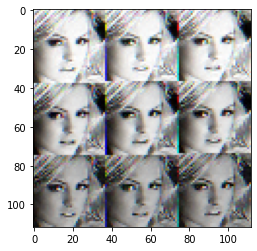

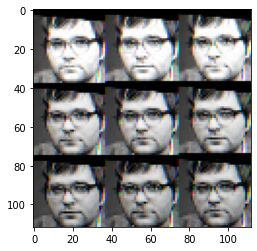

In [101]:
plt.figure()
plt.imshow(cv.cvtColor(np.reshape(images[0], (112,112,3)), cv.COLOR_BGR2RGB))
plt.figure()
plt.imshow(cv.cvtColor(np.reshape(images[350], (112,112,3)), cv.COLOR_BGR2RGB))

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

In [103]:
X_train, X_test, y_train, y_test = train_test_split(features.cpu().numpy(), labels, test_size=0.3,
                                                            random_state=42, shuffle=True)

ValueError: Found input variables with inconsistent numbers of samples: [2, 500]

In [104]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

y_train = torch.tensor(y_train).to(device)
y_test = torch.tensor(y_test).to(device)
        
        

/home/a.y.igoshin/virtual_environments/main/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/home/a.y.igoshin/virtual_environments/main/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/a.y.igoshin/virtual_environments/main/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/home/a.y.igoshin/virtual_en

In [105]:
from torch.nn.functional import cosine_similarity
# from sklearn.metrics.pairwise import cosine_similarity

In [106]:
vector1 = torch.tensor([[1, 2, 3]], dtype=torch.float32)
vector2 = torch.tensor([[3, 2, 1]] * 2, dtype=torch.float32)
cosine_similarity(vector1, vector2) 

tensor([0.7143, 0.7143])

In [107]:
target = torch.cat(list([X_test[0:1]]) * len(X_train), 0)
print(target)
print(np.shape(target))
dist = cosine_distance(features[0:1], features[1:2], dim=1)
y_hat = dist < 0.3
# y = (y_test[0] == y_train).cpu().numpy()
y = [labels[0] == labels[350]]
print(dist)
print(y_hat)
print(y)
print(y_test)
print(y_train)
# print(torch.sum(y_hat == y))
# print(y_hat == y)
# print(dist.size()[0])
# print(torch.sum(y_hat == y).cpu().numpy() / dist.size()[0])
# print(balanced_accuracy_score(y_hat.cpu().numpy(), y.cpu().numpy()))
print(balanced_accuracy_score(y, y_hat.cpu().numpy()))

tensor([[ 0.6368,  1.4053, -1.4944,  ..., -2.5022, -1.5621,  1.4761],
        [ 0.6368,  1.4053, -1.4944,  ..., -2.5022, -1.5621,  1.4761],
        [ 0.6368,  1.4053, -1.4944,  ..., -2.5022, -1.5621,  1.4761],
        ...,
        [ 0.6368,  1.4053, -1.4944,  ..., -2.5022, -1.5621,  1.4761],
        [ 0.6368,  1.4053, -1.4944,  ..., -2.5022, -1.5621,  1.4761],
        [ 0.6368,  1.4053, -1.4944,  ..., -2.5022, -1.5621,  1.4761]],
       device='cuda:2')
torch.Size([350, 512])
tensor([0.0925], device='cuda:2')
tensor([True], device='cuda:2')
[False]
tensor([5., 0., 5., 2., 0., 6., 5., 1., 0., 6., 0., 2., 6., 0., 5., 6., 7., 0.,
        5., 6., 7., 7., 4., 5., 0., 6., 7., 2., 0., 5., 6., 5., 6., 2., 0., 5.,
        6., 0., 2., 0., 6., 0., 6., 2., 0., 0., 0., 0., 6., 0., 0., 2., 2., 6.,
        2., 0., 2., 0., 2., 0., 7., 4., 5., 6., 0., 0., 6., 0., 4., 6., 5., 5.,
        4., 4., 5., 5., 4., 0., 6., 6., 2., 0., 6., 2., 5., 0., 2., 6., 5., 4.,
        5., 6., 5., 5., 6., 5., 0., 0., 6., 0

In [ ]:
target = torch.cat(list([X_test[0:1]]) * len(X_train), 0)
print(target)
print(np.shape(target))
dist = cosine_distance(features[0:1], features[1:2], dim=1)
y_hat = dist < 0.3
# y = (y_test[0] == y_train).cpu().numpy()
y = [labels[0] == labels[1]]
print(dist)
print(y_hat)
print(y)
print(y_test)
print(y_train)
# print(torch.sum(y_hat == y))
# print(y_hat == y)
# print(dist.size()[0])
# print(torch.sum(y_hat == y).cpu().numpy() / dist.size()[0])
# print(balanced_accuracy_score(y_hat.cpu().numpy(), y.cpu().numpy()))
print(balanced_accuracy_score(y, y_hat.cpu().numpy()))

In [ ]:
# [len(bucket) for bucket in buckets]
for bucket in buckets:
    print(buckets[bucket])

In [ ]:
index = 1025
header, s = recordio.unpack(imgrec.read_idx(index + 1))
img = mx.image.imdecode(s).asnumpy()
label = int(header.label)
plt.figure()
plt.imshow(img)

print(label in labels)
print(int(header.label))

In [ ]:
# import torch.functional as F

In [ ]:
# from torch.utils.data import Dataset

# class ArcFaceBucketsDataset(Dataset):

#   def __init__(self, path_imgrec, path_imgidx, buckets):
#     self.imgrec = recordio.MXIndexedRecordIO(os.path.abspath(path_imgidx), os.path.abspath(path_imgrec), 'r')
#     self.indexes = [idx for i, bucket in enumerate(buckets) for j, idx in enumerate(bucket[i])]
  
#   def __len__(self):
#     return len(self.indexes)
  
#   def __getitem__(self, idx):
#     img_idx = self.indexes[idx]
#     header, s = recordio.unpack(imgrec.read_idx(img_idx + 1))
#     target = mx.image.imdecode(s).asnumpy()
#     target = cv.cvtColor(target, cv.COLOR_RGB2BGR)

#     return target


In [ ]:
# dataset = ArcFaceBucketsDataset(path_imgrec, path_imgidx, )

In [ ]:
imgrec.reset()
def run():
    with torch.no_grad():

    header, s = recordio.unpack(imgrec.read_idx(index + 1))
    img = mx.image.imdecode(s).asnumpy()
    img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
    label = int(header.label)
    features = get_features([img], model, data_transforms['val'], flip=True)
    distances_to_centers = 1 - nn.CosineSimilarity(dim=1).forward(features.cuda(), torch.tensor(kmeans.cluster_centers_).cuda())
    distances_to_centers = distances_to_centers.cpu().numpy()
    clusters_sorted = np.argsort(distances_to_centers)

    for cluster in clusters_sorted:
        batch = get_batch(imgrec, cluster, buckets)
        features = get_features(batch, model,data_transforms['val'], flip=True)
run()

In [ ]:
# i = 10000
imgrec.reset()
def run():
  with torch.no_grad():
    count = 0
    # index  = 1015
    header, s = recordio.unpack(imgrec.read_idx(index + 1))
    img = mx.image.imdecode(s).asnumpy()
    # print(img.shape)
#     img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
    # print(header.label)
    # print(type(header.label))
    label = int(header.label)
    # images.append(img)
    # labels.append(label)
    features = get_features([img], model, data_transforms['val'], flip=True)
    distances_to_centers = [cosine(features.cpu().numpy()[0], center) for center in kmeans.cluster_centers_]
    clusters_sorted = np.argsort(distances_to_centers)
    for cluster in clusters_sorted:
        for idx in buckets[cluster]:
            print(idx)
            count += 1
            header, s = recordio.unpack(imgrec.read_idx(idx + 1))
            target = mx.image.imdecode(s).asnumpy()
#             target = cv.cvtColor(target, cv.COLOR_RGB2BGR)
#             print(img.shape)
            item = get_features([target], model,data_transforms['val'], flip=True)

            # item = torch.cat(item)
            # diff = item.cuda().unsqueeze(-1) - features.cuda().transpose(1, 0).unsqueeze(0)
            # dist = torch.sum(torch.pow(diff, 2), dim=1)
            if labels[idx] == label:
              print('Win!')
              plt.figure()
              plt.imshow(cv.cvtColor(target, cv.COLOR_BGR2RGB))
            # print(dist)
            print(nn.CosineSimilarity(dim=1).forward(features.cuda(), item.cuda()))
            if nn.CosineSimilarity(dim=1).forward(features.cuda(), item.cuda()) > 0.7:
            # if dist < 4:
                # print(1 - cosine(features, item))
                plt.figure()
                plt.imshow(img)
                plt.figure()
                plt.imshow(target)
                return labels[idx], label
    print(count)
print(run())
# print(count)

In [ ]:
# for j in range(i, i + 10):
#     try:
#         index = j + 1
#         header, s = recordio.unpack(imgrec.read_idx(j+ 1))
#         img = mx.image.imdecode(s).asnumpy()
#         # print(img.shape)
#         img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
#         # print(header.label)
#         # print(type(header.label))
#         label = int(header.label)
#         images.append(img)
#         labels.append(label)
#         tensor = torch.FloatTensor(img).view(1, 3, 112, 112)
#         tensor = tensor.to(device)
#         result = model.forward(tensor)
#         distance_to_centers = cosine(result, cluster_centers_)
        
        
#         if (index - i) % batch_size == 0:
#             print(index)
#             print(np.shape(images))
#             tensor = torch.FloatTensor(images).view(batch_size, 3, 112, 112)
#             tensor = tensor.to(device)
#             result = model.forward(tensor)
#             print(np.shape(result))
#             distances_to_centers = [x for vec in result]
#             ids = kmeans.transform(result.detach().numpy())
            
#             for j, cluster in enumerate(ids):
#                 if buckets.get(cluster, None) is None:
#                     buckets.update({cluster: []})
#                 buckets[cluster].append(i - 256 + j)
#             labels = []
#             images = []
#         if i > 5000:
#             break
#         i += 1
#     except Exception as e:
#         print(e)
#         break

In [ ]:
# import math
# math.cos(math.pi - args.margin_m)